In [1]:
def log_loss(true_labels, predicted_probs):
    loss = 0
    for i in range(len(true_labels)):
        y_true = true_labels[i]
        y_pred = predicted_probs[i][1]
        loss += -(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss / len(true_labels)

In [2]:
NOISE = 200

from scipy.ndimage.interpolation import rotate

def add_noise(images, coeff=50):
    noise = np.random.uniform(low=-coeff, high=coeff, size=images.shape)
    noisy_images = images + noise
    return noisy_images

/tmp/ipykernel_14567/1799762949.py:3: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate


In [3]:
def classwise_ece(y_true, y_prob, n_bins=10):
    n_classes = y_true.shape[1]
    ece = 0.0
    for c in range(n_classes):
        y_class = y_true[:, c]
        y_prob_class = y_prob[:, c]
        bins = np.linspace(0, 1, n_bins + 1)
        bin_indices = np.digitize(y_prob_class, bins) - 1
        bin_sizes = np.bincount(bin_indices, minlength=n_bins)
        bin_probs = np.bincount(bin_indices, weights=y_prob_class, minlength=n_bins) / (bin_sizes + 1e-10)
        bin_accuracies = np.bincount(bin_indices, weights=y_class, minlength=n_bins) / (bin_sizes + 1e-10)
        ece_class = np.abs(bin_accuracies - bin_probs).dot(bin_sizes / y_class.shape[0])
        ece += ece_class
    ece /= n_classes
    return ece

In [4]:
from scipy.stats import pearsonr

def pearson_correlation(y_pred_prob1, y_pred_prob2):
    n_classes = y_pred_prob1.shape[1]
    corrs = np.zeros(n_classes)
    for class_idx in range(n_classes):
        corrs[class_idx], _ = pearsonr(y_pred_prob1[:, class_idx], y_pred_prob2[:, class_idx])
    return corrs

In [49]:
from mnist import MNIST
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage.transform import rotate
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from tqdm import tqdm
import pandas as pd


mndata = MNIST('data')

images, labels = mndata.load_training()
images = images[:1000]
labels = labels[:1000]
images = np.array(images)

noisy_images = add_noise(images, NOISE)

# noise = np.random.randint(0, 256, size=images.shape)
# noisy_images = np.abs(images - noise)

In [6]:
test_images, test_labels = mndata.load_testing()
test_images = np.array(test_images[:100])
test_labels = np.array(test_labels[:100])

for noise in range (0, NOISE, 50):
    test_noisy_images = add_noise(test_images, noise)

    test_images = np.concatenate((test_images, test_noisy_images), axis=0)
    test_labels = np.concatenate((test_labels, test_labels), axis=0)

regular image: 
noisy image: 


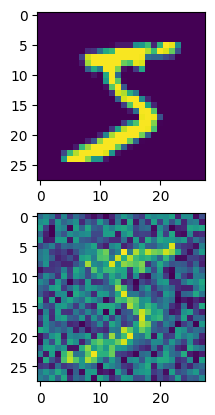

In [7]:
figure, axis = plt.subplots(2)
print("regular image: ")
axis[0].imshow(np.array(images[0]).reshape(28, 28))
print ("noisy image: ")
axis[1].imshow(np.array(noisy_images[0]).reshape(28, 28))

plt.show()

In [8]:
# correlation_matrix = np.corrcoef(images.reshape(1000, 784), noisy_images.reshape(1000, 784))
# pearson_correlation = correlation_matrix[0, 1]
# print('Pearson correlation:', pearson_correlation)

# Training the model using the original data

In [9]:
model1 = svm.SVC(probability=True)
model1.fit(images, labels)

y_prob1 = model1.predict_proba(test_images)

              precision    recall  f1-score   support

           0       1.00      0.93      0.96       128
           1       1.00      0.42      0.59       224
           2       0.19      0.98      0.32       128
           3       0.74      0.76      0.75       176
           4       0.97      0.54      0.69       224
           5       0.66      0.78      0.71       112
           6       0.98      0.41      0.58       160
           7       0.97      0.41      0.57       240
           8       0.58      0.34      0.43        32
           9       0.88      0.56      0.69       176

    accuracy                           0.59      1600
   macro avg       0.80      0.61      0.63      1600
weighted avg       0.85      0.59      0.64      1600



<AxesSubplot: >

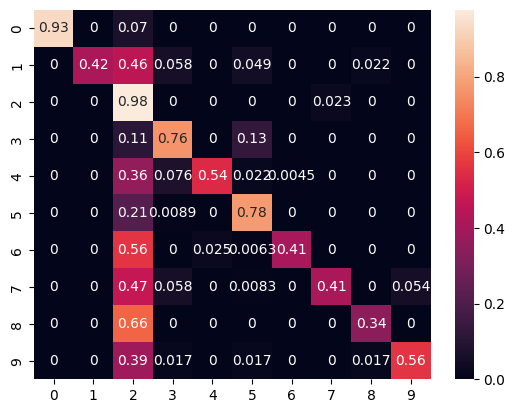

In [10]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(np.array(test_labels), np.argmax(y_prob1, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax(y_prob1, axis=1), normalize="true"),annot=True)

### Estimated calibration error

In [11]:
ece_value1 = classwise_ece(np.eye(10)[test_labels], y_prob1)
log_loss1 = log_loss(test_labels, y_prob1) 
print("Expected Calibration Error:", ece_value1)
print("The log loss:", log_loss1)

Expected Calibration Error: 0.0782006716998421
The log loss: 20.7786545309868


# Training the model using the noisy data

In [12]:
from sklearn import svm
model2 = svm.SVC(probability=True)
model2.fit(noisy_images, labels)

y_prob2 = model2.predict_proba(test_images)


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       128
           1       0.85      1.00      0.92       224
           2       0.69      0.46      0.55       128
           3       0.98      0.70      0.82       176
           4       0.71      0.87      0.78       224
           5       0.58      0.63      0.61       112
           6       0.87      0.65      0.74       160
           7       0.90      0.90      0.90       240
           8       0.63      0.81      0.71        32
           9       0.73      0.81      0.77       176

    accuracy                           0.81      1600
   macro avg       0.79      0.78      0.78      1600
weighted avg       0.81      0.81      0.80      1600



<AxesSubplot: >

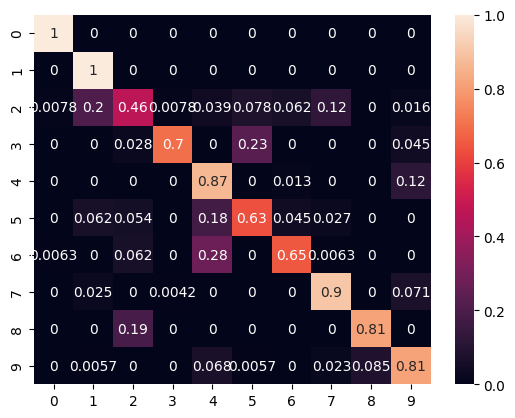

In [13]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(np.array(test_labels), np.argmax(y_prob2, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax(y_prob2, axis=1), normalize="true"),annot=True)

In [14]:
ece_value2 = classwise_ece(np.eye(10)[test_labels], y_prob2)
log_loss2 = log_loss(test_labels, y_prob2) 
print("Expected Calibration Error:", ece_value2)
print("The log loss:", log_loss2)

Expected Calibration Error: 0.02246060069839665
The log loss: 33.186986056513184


# Correlation between the two models

In [15]:
print('Pearson correlation:', np.mean(pearson_correlation(y_prob1, y_prob2)))

Pearson correlation: 0.7326677902132764


# Cooperative inference of the two models

In [16]:
ece_value1 = classwise_ece(np.eye(10)[test_labels], (y_prob1 + y_prob2)/2)
log_loss_avg = log_loss(test_labels, (y_prob1 + y_prob2)/2) 
print("Expected Calibration Error:", ece_value1)
print("The log loss:", log_loss_avg)

Expected Calibration Error: 0.04999295626562199
The log loss: 21.283681238139582


In [17]:
def weighted_average(model1_probs, model2_probs, model1_ece, model2_ece):
    weight1 = 1 / model1_ece
    weight2 = 1 / model2_ece
    total_weight = weight1 + weight2
    weight1 /= total_weight
    weight2 /= total_weight
    avg_probs = weight1 * model1_probs + weight2 * model2_probs
    return avg_probs

In [18]:
y_prob_weighted = weighted_average(y_prob1, y_prob2, ece_value1, ece_value2)

In [19]:
ece_value2 = classwise_ece(np.eye(10)[test_labels], y_prob_weighted)
log_loss_weighted = log_loss(test_labels, y_prob_weighted) 

print("Expected Calibration Error:", ece_value2)
print("The log loss:", log_loss_weighted)

Expected Calibration Error: 0.036934826084542696
The log loss: 22.214674212444066


              precision    recall  f1-score   support

           0       0.98      1.00      0.99       128
           1       0.88      1.00      0.93       224
           2       0.65      0.54      0.59       128
           3       0.97      0.72      0.83       176
           4       0.74      0.88      0.80       224
           5       0.62      0.68      0.65       112
           6       0.88      0.63      0.73       160
           7       0.90      0.91      0.91       240
           8       0.63      0.81      0.71        32
           9       0.74      0.81      0.77       176

    accuracy                           0.82      1600
   macro avg       0.80      0.80      0.79      1600
weighted avg       0.82      0.82      0.81      1600



<AxesSubplot: >

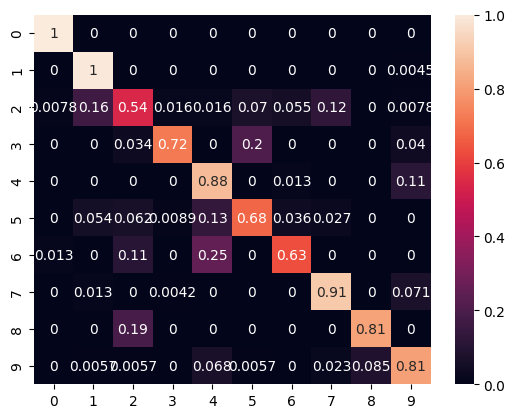

In [20]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(np.array(test_labels), np.argmax(y_prob_weighted, axis=1)))
sns.heatmap(confusion_matrix(np.array(test_labels), np.argmax(y_prob_weighted, axis=1), normalize="true"),annot=True)

# Noise-correlation relationship

In [34]:
def build_test_model(train_images, train_labels, test_images, test_labels):
    model = svm.SVC(probability=True)
    model.fit(train_images, train_labels)

    y_prob = model.predict_proba(test_images)
    ece_value = classwise_ece(np.eye(10)[test_labels], y_prob)
    correlation_coefficient = np.mean(pearson_correlation(y_prob1, y_prob))
    return ece_value, correlation_coefficient, y_prob

In [36]:
correlation_coefficients = []

images, labels = mndata.load_training()
images = np.array(images[:100])
labels = np.array(labels[:100])

for noise in tqdm(range (0, NOISE, 20)):
    noisy_images = add_noise(images, noise)

    _, correlation_coefficient, _ = build_test_model(noisy_images, labels, test_images, test_labels)
    correlation_coefficients.append(correlation_coefficient)
    

100%|██████████| 10/10 [00:01<00:00,  9.16it/s]


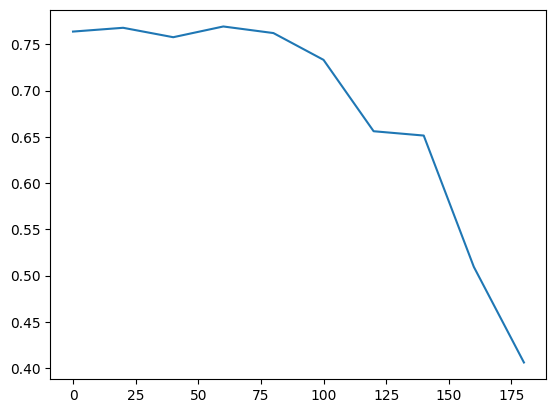

In [37]:
plt.plot(range(0, NOISE, 20), correlation_coefficients)
plt.show()

# Study: the correlation of the models and the effect on the bayesian averaging

In [71]:
import random
correlation_coefficients = []
ece_values = []

images, labels = mndata.load_training()
images = np.array(images[:100])
labels = np.array(labels[:100])

for noise in tqdm(range (0, 100)):
    noise = random.randint(0, NOISE)
    noisy_images = add_noise(images, noise)
    _, _, y_prob1 = build_test_model(noisy_images, labels, test_images, test_labels)

    noise = random.randint(0, NOISE)
    noisy_images = add_noise(images, noise)
    _, _, y_prob2 = build_test_model(noisy_images, labels, test_images, test_labels)
    
    
    
    correlation_coefficient = np.mean(pearson_correlation(y_prob1, y_prob2))
    correlation_coefficients.append(correlation_coefficient)

    ece_value = classwise_ece(np.eye(10)[test_labels], (y_prob2 + y_prob1)/2)

    ece_values.append(ece_value)

    

100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


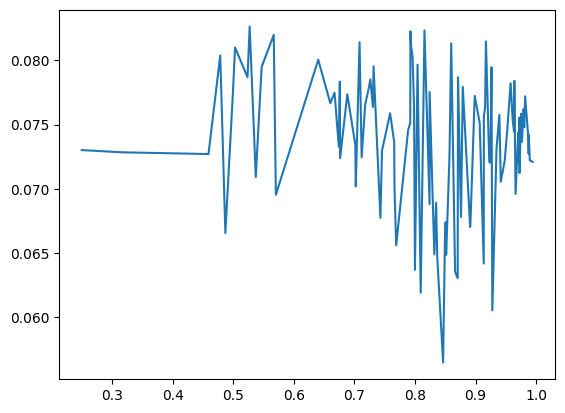

In [73]:
df = pd.DataFrame()
df["correlation_coefficient"] = correlation_coefficients
df["ece_value"] = ece_values/np.mean(ece_values)

df = df.sort_values("correlation_coefficient")
plt.plot(df["correlation_coefficient"], df["ece_value"])
plt.show()

# Study: the correlation of the models and the effect on the weighted bayesian averaging

In [77]:
import random
correlation_coefficients = []
ece_values = []
ece_values1 = []
ece_values2 = []

images, labels = mndata.load_training()
images = np.array(images[:100])
labels = np.array(labels[:100])

for noise in tqdm(range (0, 100)):
    noise = random.randint(0, NOISE)
    noisy_images = add_noise(images, noise)
    ece_value1, _, y_prob1 = build_test_model(noisy_images, labels, test_images, test_labels)
    ece_values1.append(ece_value1)

    noise = random.randint(0, NOISE)
    noisy_images = add_noise(images, noise)
    ece_value2, _, y_prob2 = build_test_model(noisy_images, labels, test_images, test_labels)
    ece_values2.append(ece_value2)
    
    
    
    correlation_coefficient = np.mean(pearson_correlation(y_prob1, y_prob2))
    correlation_coefficients.append(correlation_coefficient)

    ece_value = classwise_ece(np.eye(10)[test_labels], weighted_average(y_prob2, y_prob2, ece_value1, ece_value2))

    ece_values.append(ece_value)

    

100%|██████████| 100/100 [00:19<00:00,  5.13it/s]


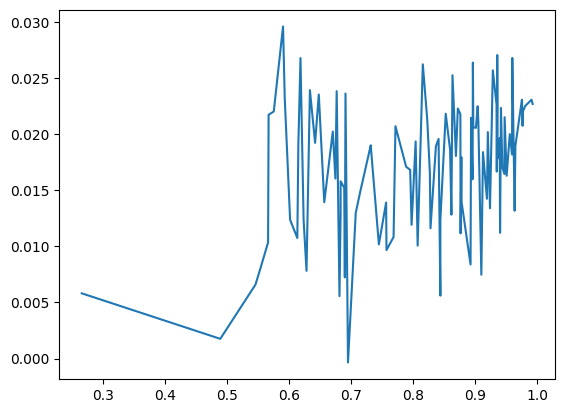

In [81]:
df = pd.DataFrame()
df["correlation_coefficient"] = correlation_coefficients
df["ece_value"] = ece_values
df["ece_value1"] = ece_values1
df["ece_value2"] = ece_values2

df = df.sort_values("correlation_coefficient")
plt.plot(df["correlation_coefficient"], df["ece_value"] - np.min(np.array(df["ece_value1"], df["ece_value2"])))
plt.show()

# Test

In [82]:
import h5py
with h5py.File('usps.h5', 'r') as hf:
        train = hf.get('train')
        X_tr = train.get('data')[:]
        y_tr = train.get('target')[:]
        test = hf.get('test')
        X_te = test.get('data')[:]
        y_te = test.get('target')[:]

In [85]:
X_tr[0].shape

(256,)

regular image: 
noisy image: 


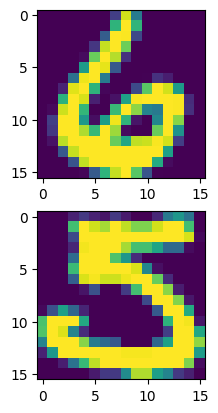

In [86]:
figure, axis = plt.subplots(2)
print("regular image: ")
axis[0].imshow(np.array(X_tr[0]).reshape(16, 16))
print ("noisy image: ")
axis[1].imshow(np.array(X_tr[1]).reshape(16, 16))

plt.show()

- Intoduce inbalance in data (done)

- Have balanced data (done)

- Plot the calibration curve (done)

- Tansform the task to be more difficult for SVM (swapping labels wrongly labeled) (done)

- Two models that have different qualities (done)

- SVM playing on the dataset

- experiment with more values for lambda (done)

- Sequentiality in inference (some experiments): if the  other model provides a better inference, should I take it or just  use its prediction, other model may be better at a certain classes. Maybe this forwarding mechanism may be better than combining the two models.

- Calibration error of model trained on whole dataset vs cooperative model (done)

- Evaluation of the sequential serving of the models

- Tradeoff between the calculations vs accuracy (do I us local model or  not for example we change the level of confidence to actually accept an inference or ask the other model)

- If I use both the local output and other inference I should get better inference, if I am not confident and set a high threshold and rely on the other model he may be less confidence and I still take his inference and thus get a worse accuracy in general (accuracy-delay curve), do it to early exit too. 

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e76c8840-118e-4c48-bc4e-42f2efb5350a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>